Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /workspaces/jjh-gpu1-temp/IDSL/pytorch_SEFS/logs/baseline/beta-0.05/l1_coef-0.0001/ss_epochs-1000/seed-1/label_size--10
2024-02-09 14:17:26.054571: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-09 14:17:26.083155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cu

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/workspaces/jjh-gpu1-temp/IDSL/NSFMR/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/workspaces/jjh-gpu1-temp/IDSL/NSFMR/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/workspaces/jjh-gpu1-temp/IDSL/NSFMR/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s, v_num=0, self-supervision/train_x=0.100, self-supervision/train_m=6.930, self-supervision/train_total=69.50, self-supervision/val_x=0.100, self-supervision/val_m=6.930, self-supervision/val_total=69.50] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 27.35it/s, v_num=0, self-supervision/train_x=0.100, self-supervision/train_m=6.930, self-supervision/train_total=69.50, self-supervision/val_x=0.100, self-supervision/val_m=6.930, self-supervision/val_total=69.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | SEFS_S_Phase | 31.8 K
---------------------------------------
31.8 K    Trainable params
0         Non-trainable params
31.8 K    Total params
0.127     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 43.30it/s, v_num=1, supervision/train_total=0.0512, supervision/train_y=0.0264, supervision/val_total=0.0421, supervision/val_y=0.0172]   

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s, v_num=1, supervision/train_total=0.0512, supervision/train_y=0.0264, supervision/val_total=0.0421, supervision/val_y=0.0172]


<BarContainer object of 100 artists>

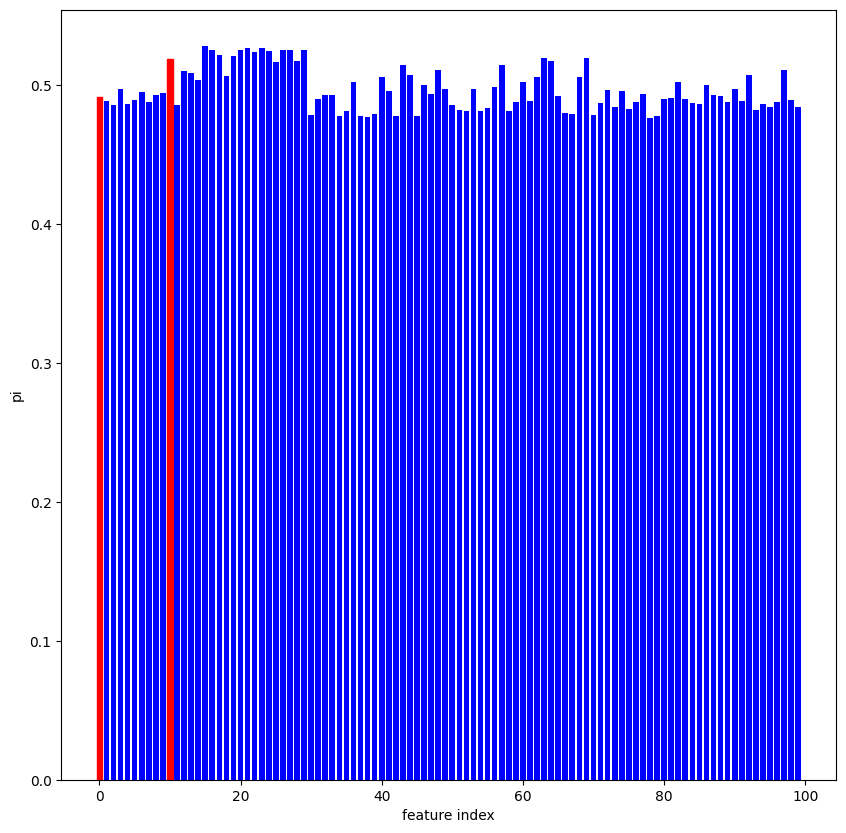

In [1]:
import argparse
from datetime import datetime
import numpy as np
from src.data.synthetic_data import SyntheticData
from src.data.data_wrapper import DataWrapper
from src.SEFS import SEFS
from src.models_common import ACTIVATION_TABLE
from src.supervision.model import SEFS_S_Phase
from matplotlib import pyplot as plt
def parse_args():
    parser = argparse.ArgumentParser()



    # model params
    parser.add_argument("--prob_type", type=str, default="twomoon", choices=["twomoon", "opls","deeppink"],)
    parser.add_argument("--seed",type=int,default=1)
    # data size
    parser.add_argument("--label_size", type=int, default=10, help="size of labeled data")
    parser.add_argument("--noise", type=int, default=0.1, help="size of labeled data")
    parser.add_argument("--unlabel_size", type=int, default=1000, help="size of unlabeled data")


    parser.add_argument("--z_dim", type=int, default=10, help="dimension of latent variable")

    parser.add_argument("--h_dim_e", type=int, default=100, help="dimension of hidden layers in encoder")
    parser.add_argument("--num_layers_e", type=int, default=3, help="number of hidden layers in encoder")

    parser.add_argument("--h_dim_d", type=int, default=10, help="dimension of hidden layers in decoder")
    parser.add_argument("--num_layers_d", type=int, default=3, help="number of hidden layers in decoder")

    parser.add_argument("--dropout", type=float, default=0.0, help="dropout rate")
    parser.add_argument("--fc_activate_fn", type=str, default="relu", choices=list(ACTIVATION_TABLE.keys()),
                        help="activation function in fully connected layers")

    # trainer params
    parser.add_argument("--alpha", type=float, default=10, help="regularization coefficient for m in self-supervision phase")
    parser.add_argument("--beta", type=float, default=0.05, help="regularization coefficient for pi in supervision phase")
    parser.add_argument("--l1_coef", type=float, default=0.0001, help="regularization coefficient for l1 norm of weights")
    parser.add_argument("--lr", type=float, default=1e-4, help="learning rate")
    parser.add_argument("--weight_decay", type=float, default=1e-5, help="weight decay")

    # lightning params
    parser.add_argument("--ss_epochs", type=int, default=1000, help="trainin epochs for self-supervision phase")
    parser.add_argument("--s_epochs", type=int, default=1000, help="trainin epochs for supervision phase")

    parser.add_argument("--ss_batch_size", type=int, default=1024, help="batch size for self-supervision phase")
    parser.add_argument("--s_batch_size", type=int, default=32, help="batch size for supervision phase")
    parser.add_argument("--gradient_clip_val", type=float, default=1.0, help="gradient clip value in l2 norm")

    return parser.parse_args("")


def get_log_dir(args):
    #
    # Do some jobs here with args to create a experiment name with the given arguments.
    # Deafult is set to return "test"
    # cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    # exp_name = f'test_{cur_time}'
    
    exp_name = f"baseline/beta-{args.beta}/l1_coef-{args.l1_coef}/ss_epochs-{args.ss_epochs}/seed-{args.seed}/label_size--{args.label_size}"

    return exp_name



    #args.seed=seed
args=parse_args()
data = DataWrapper(SyntheticData(args.prob_type,200,40,1000,args.seed))
val_data = DataWrapper(SyntheticData(args.prob_type,200,40,1000,456))


# NOTE: if you want to change the default values of the parameters, you can do it here.
# i.e., args.z_dim = 2**7

model_params = {
        'x_dim': data.x_dim,
        'z_dim': args.z_dim,
        'h_dim_e': args.h_dim_e,
        'num_layers_e': args.num_layers_e,

        'h_dim_d': args.h_dim_d,
        'num_layers_d': args.num_layers_d,

        'dropout': args.dropout,
        'fc_activate_fn': args.fc_activate_fn,
}

trainer_params = {
        'alpha': args.alpha,
        'beta': args.beta,
        'l1_coef': args.l1_coef,
        'optimizer_params': {
            'lr':  args.lr,
            'weight_decay': args.weight_decay,
        },
    }

ss_lightning_params = {
        'max_epochs': args.ss_epochs,
        'precision': "16-mixed",
        'gradient_clip_val': args.gradient_clip_val,
        'batch_size': args.ss_batch_size,
}

s_lightning_params = {
        'max_epochs': args.s_epochs,
        'precision': "16-mixed",
        'gradient_clip_val': args.gradient_clip_val,
        'batch_size': args.s_batch_size,
}

sefs = SEFS(
    train_data=data,
    val_data=val_data,
    selection_prob=np.array([0.5 for _ in range(data.x_dim)]),
    model_params=model_params,
    trainer_params=trainer_params,
    ss_lightning_params=ss_lightning_params,
    s_lightning_params=s_lightning_params,
    exp_name=get_log_dir(args), # this is the name of the experiment.
                                # you can change it to whatever you want using the function above.
                                
    early_stopping_patience=10000
)

sefs.train()
feat_imp_idx =data.get_feature_importance()
pi = sefs.supervision_phase.model.get_pi()
pi = pi.detach().cpu().numpy()
pi = pi.reshape(-1)
#plt.bar(range(len(pi)),pi)
color = ['r' if i in feat_imp_idx else 'b' for i in range(len(pi))]
plt.bar(range(len(pi)),pi,color=color)
    




